In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt


## Format of our data

Our data is a JSON file that contains entries for each frame of a video (or multiple videos). Each entry contains the following fields:<br>
    "position": name of the position (our label data)<br>
    "image": an image id (not relevant for us)<br>
    "frame": the frame number (not relevant for us)<br>
    "pose1": the coordinates of person1<br>
    "pose2": the coordinates of person2<br>
Sometimes pose1 or pose2 could be missing, but at least one of them is present

In [3]:
# Global variables
json_file = 'annotations.json'
final_json_file = 'final_data.json'

In [4]:
# Load JSON File
def process_json_file(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
        return data

## Visualize the data

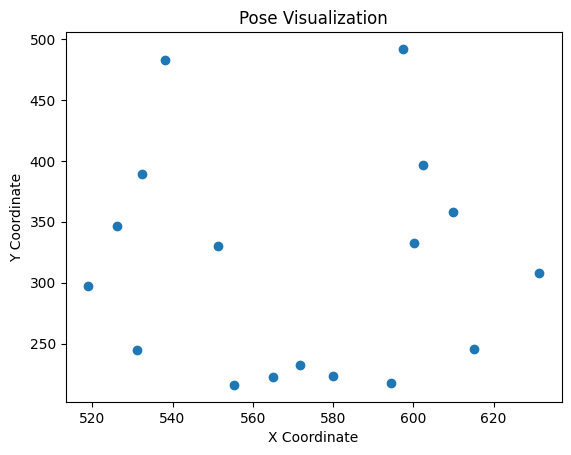

In [5]:
# Demo of an open guard position in test.json (contains some dummy entries)
data = process_json_file('test.json')[0]


# Extract 'pose2' data
pose2_data = data['pose2']

# Convert to NumPy array
pose2_array = np.array(pose2_data)

# Extract X and Y coordinates
x_coordinates = pose2_array[:, 0]
y_coordinates = pose2_array[:, 1]

# Create a scatter plot
plt.scatter(x_coordinates, y_coordinates)

# Add labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Pose Visualization')

plt.show()

In [9]:
# For this challenge, I will train a model on 5 different classes (I will take the classes that have the most entries)

classes = ["standing", "open_guard1", "open_guard2", "takedown1", "takedown2","half_guard1", "half_guard2", "closed_guard1", "closed_guard2", "5050_guard", "side_control1",  "side_control2", "mount1", "mount2", "back1", "back2", "turtle1", "turtle2"]
count = {cls: 0 for cls in classes}

In [30]:
def getCount(filename, count):
    data = process_json_file(filename)
    for entry in data:
        label = entry['position']
        count[label] += 1
    return count

count = getCount('annotations.json', count)

In [37]:
count

{'standing': 16723,
 'open_guard1': 7884,
 'open_guard2': 7355,
 'takedown1': 2618,
 'takedown2': 2586,
 'half_guard1': 4697,
 'half_guard2': 5904,
 'closed_guard1': 6136,
 'closed_guard2': 5560,
 '5050_guard': 8453,
 'side_control1': 6055,
 'side_control2': 5205,
 'mount1': 5943,
 'mount2': 5794,
 'back1': 7063,
 'back2': 6156,
 'turtle1': 8536,
 'turtle2': 7613}

In [48]:
# I will take the most frequent positions to simplify the process
sortedPosn = sorted(count.items(), key=lambda item: item[1])
positions_to_keep = sortedPosn[-8:]
final_classes = {name for name, _ in positions_to_keep}
final_classes

{'5050_guard',
 'back1',
 'back2',
 'open_guard1',
 'open_guard2',
 'standing',
 'turtle1',
 'turtle2'}

In [49]:
# We will make a new json file containing only the classes mentioned above
def make_new_json_file_with_relevant_data(filename, final_classes, new_filename):
    data = process_json_file(filename)
    filtered_data = [entry for entry in data if entry['position'] in final_classes]
    with open(new_filename, 'w') as file:
        json.dump(filtered_data, file, indent=4)
    print("Data dump to new file successful")

In [52]:
make_new_json_file_with_relevant_data(json_file, final_classes, "final_data.json")


Data dump to new file successful


In [56]:
# Check for inconsistencies in the data 
def get_shape_of_data(filename):
    data = process_json_file(filename)
    shapes = []
    for entry in data:
        if 'pose1' in entry:
            shape1 = len(entry['pose1'])
            if (shape1 not in shapes):
                shapes.append(shape1)
        if 'pose2' in entry:
            shape2 = len(entry['pose2'])
            if (shape2 not in shapes):
                shapes.append(shape2)
    return shapes

In [10]:
get_shape_of_data(final_json_file)
# Output is 17, as expected, since each frame should have 17 landmarks, as indicated in the MS-COCO Pose Estimation Documentation
# So no inconsistencies in the data, we can proceed to the next step

NameError: name 'get_shape_of_data' is not defined

In [ ]:
# In our input data, we are given, for each entry, either pose1 and/or pose2
# To make the data uniform and to facilitate the training using a Dense Neural Network, we will combine both entries into a single one
# To determine which array (pose1 or pose2) will be stacked on top of our new array (called pose), we will check if the position name ends with a string and match the format of the array to that, otherwise default to pose1 going on top
# If either pose1 or pose2 is missing, then we will create an array of zeroes of shape (17, 3) for padding (and stack it at the bottom)
def format_landmarks(entry):
    list_17x3 = [[0 for _ in range(3)] for _ in range(17)]
    posName = entry["position"]
    if posName.endswith("2"):
        if 'pose2' in entry:
            pose = entry["pose2"]
            if 'pose1' in entry:
                pose.extend(entry["pose1"])
            else:
                pose.extend(list_17x3)
        else:
            pose = list_17x3
            pose.extend(entry["pose1"])
    else:
        if 'pose1' in entry:
            pose = entry["pose1"]
            if 'pose2' in entry:
                pose.extend(entry["pose2"])
            else:
                pose.extend(list_17x3)
        else:
            pose = list_17x3
            pose.extend(entry["pose2"])
    entry["pose"] = pose
    entry.pop("pose1", None)
    entry.pop("pose2", None)
    return entry

def create_formatted_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    formatted_data = [format_landmarks(entry) for entry in data]
    with open('formatted_data.json', 'w') as file:
        json.dump(formatted_data, file)
create_formatted_file(final_json_file)

: 

In [6]:
# Last aspect of the preprocessing: reformat the labels for training: since our task is to simply identify the movement, we do not need to differentiate between movement1 and movement2, like the dataset did
# Thus, we will merge both labels into one
# This will also allow a better balancing in the dataset (so each label has about the same amount of data), therefore decreasing the chances of overfitting
labels = ['5050_guard',
 'back1',
 'back2',
 'open_guard1',
 'open_guard2',
 'standing',
 'turtle1',
 'turtle2']
def change_label(entry):
    if entry['position'] in ['open_guard1', 'open_guard2']:
        entry['position'] = 'open_guard'
    elif entry['position'] in ['back1', 'back2']:
        entry['position'] = 'back'
    elif entry['position'] in ['turtle1', 'turtle2']:
        entry['position'] = 'turtle'
    return entry
    
def process_labels(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    processed_data = [change_label(entry) for entry in data]
    with open(filename, 'w') as file:
        json.dump(processed_data, file)

process_labels('formatted_data.json')
    


In [7]:
count = {}
def getCount(filename, count):
    data = process_json_file(filename)
    for entry in data:
        label = entry['position']
        if label not in count:
            count[label] = 1
        count[label] += 1
    return count

getCount('formatted_data.json', count)
# From the output, the dataset is overall well-balanced, although the '5050_guard' is under-represented. We could use a random oversampling technique to improve balance

{'standing': 16723,
 'open_guard': 15239,
 '5050_guard': 8454,
 'turtle': 16150,
 'back': 13220}